In [25]:
import pandas as pd
import numpy as np
import scipy as sp
import networkx as nx #To generate G(n,p) adj matrix

import math
import random
import sys

In [26]:
##A small utility
import time                                                

def timeit(method):

    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print '%r (%r, %r) %2.2f sec' % \
              (method.__name__, args, kw, te-ts)
        return result

    return timed


ERROR! Session/line number was not unique in database. History logging moved to new session 2


In [27]:

class HamiltonianWorker(object):
    '''Class in charge of managing states and
    efficient energy calculation.
    
    Note: colors' index starts at 1. Vertex indices
    start at 0. (see broadcasting)
    '''
    
    def __init__(self, q=3, n=100, c=5):
        
        adj_matrix = self.__AdjMx_From_Gnp(n,float(c)/n)
        ##Initial Coloring
        self.q=q
        self.X = pd.Series(np.random.randint(low=1,high=q+1,size=adj_matrix.shape[0]))
        #COLORED adj_matrix e.g. A[i,j] = color of j. A[j,i]=color or i
        self.A = adj_matrix.multiply(self.X,axis=1)
        self.n = self.A.shape[0]
        # Get initial energy. Hamiltonian energy function.
        self.SumIdx = self.A.apply(lambda col:col==self.X).sum(axis=1) #Store count of bad edges indexed by vertex
        self.E = int(self.SumIdx.sum())
        if self.E%2 != 0:
            sys.exit('E from colored adj_matrix ashould be even')
            
        self.E = self.E/2.0
        # No vertex should have index 0. This is 'null' state and energy.
        self.X_new = np.zeros(self.A.shape[0])
        self.E_new = -1
        
        
    def walk(self,T, T_Period):
        '''
        Walks T_period steps the Markov Chain for a fixed temperature parameter.
        @param T: temperature
        @param T_Period: number of steps. This is the epoch for each temperature update.
        @return Energy: last Energy found.
        @return X: last coloring found.
        @return dsc_ratio: descent ratio. e.g. nb of times dE<=0
        @return stct_dsc_ratio: strict descent ratio. e.g. nb of times dE<0
        '''
        assert T>=0.0, 'Temperature parameter must be positive, use bootstrap() method in case of no initial guess.'
        if T==0.0:
            raise ValueError('T has hit 0.0, use bootstrap() method in case of no initial guess.')
        descents, strict_descents = 0,0
        for k in range(T_Period):
            newColor, newEnergy = self.__next_state_and_energy()
            dE = newEnergy - self.E
            if dE > 0.0 and math.exp(-dE/T) >= random.random():
                self.__update(newColor, newEnergy)
            elif dE<=0:
                descents += 1
                if dE < 0.0 :
                    strict_descents +=1
                self.__update(newColor,newEnergy)
                
        return (self.E, float(descents)/T_Period, float(strict_descents)/T_Period)
    
    
    def bootstrap(self):
        '''Call in case no T parameter is guessed '''
        T,steps = 0.0,0
        prevEnergy = self.E
        while T==0.0:
            steps+=1
            newColor,newEnergy = self.__next_state_and_energy()
            self.__update(newColor,newEnergy)
            T = abs(self.E - prevEnergy)
            prevEnergy = self.E
        return T,steps
       
        
    def __AdjMx_From_Gnp(self,n,p):
        
        G_np=nx.fast_gnp_random_graph(n,p) #Undirected graph by default
        adj_matrix = nx.adjacency_matrix(G_np)
        adj_matrix = adj_matrix.toarray()

        if not (adj_matrix.transpose() == adj_matrix).all():
            sys.exit('Non-symmetric adjacency matrix')
        if np.any(adj_matrix.diagonal()):
            sys.exit('No self loops allowed.')
    
        return pd.DataFrame(adj_matrix)
    
    
    def __update(self,X_new, E_new): 
        '''update when sampling is accepted'''
        if ((E_new != self.E_new) or (not (X_new==self.X_new).all())):
            sys.exit('New state and energy should have been generated by Hamiltonian on previous step.')
                 
        #Update sum cache (SumIdx)
#         self.SumIdx.iloc[self.u_idx] = (self.A.iloc[self.u_idx,:] == X_new.iloc[self.u_idx]).sum()
#         for i in xrange(self.n):
#             if i != self.u_idx and self.A.iloc[i,self.u_idx] != 0:
#                 self.SumIdx.iloc[i] += int(self.X.iloc[i] == X_new.iloc[self.u_idx]) - int(self.X.iloc[i] == self.X.iloc[self.u_idx])
        #Re-Color Matrix
        new_color = X_new.iloc[self.u_idx]
        self.A.iloc[:,self.u_idx][self.A.iloc[:,self.u_idx]!=0] = new_color
        
#         print self.E, '->' ,E_new
        
        self.X = X_new
        self.E = E_new
        
#         assert(int(self.E*2)==int(self.SumIdx.sum()))

        self.X_new = np.zeros(self.n)
        self.E_new = -1
        self.u_idx = -1
        
          
    def __next_state_and_energy(self):
        '''calculate next state and its energy
        Both are sent at the same time for efficiency'''
            
        self.u_idx = np.random.randint(self.n)
        next_X = self.X.copy(deep=True)
        next_X.iloc[self.u_idx] = np.random.choice(np.delete(np.arange(1,self.q+1),next_X.iloc[self.u_idx]-1)) 
        self.X_new = next_X
        self.E_new = self.__new_energy()
#         print self.E, '->', self.E_new
        return (self.X_new, self.E_new)
        
    def __new_energy(self):
        '''Calculation is done with respect to candidate update.
        Otherwise, hamiltonian energy function can be donde costly to
        calculate from scratch'''
        old_sum = self.E
        sum_old = (self.A.iloc[self.u_idx,:] == self.X.iloc[self.u_idx]).sum()
        sum_update = (self.A.iloc[self.u_idx,:] == self.X_new.iloc[self.u_idx]).sum()
        delta = (sum_update - sum_old)
        return old_sum + delta
    def get_E_from_scratch():
        return self.A.apply(lambda col:col==self.X).sum(axis=1).sum()/2.0    


In [28]:


class BlackSmith(object):
    
    '''The One who does annealing'''
    def __init__(self,schedule=None,q=2,n=100,desc_thresh=0.98,T_Period=10,workline=None):
        self.q=q
        self.n=n
        self.desc_thresh = desc_thresh
        self.T_Period = T_Period
        self.workline = workline
        if schedule not in ['Cauchy','Fast','Exp']:
            sys.exit('Unknown temperature schedule')
        self.schedule = schedule
        
    def work(self):
        'Print annealing schedule started...'
        
        for mean_deg,temperature in self.workline:
            yield (mean_deg,temperature,self.__anneal(c=mean_deg,temp=temperature))
        
    @timeit
    def __anneal(self,c=5,temp=None):
        '''One annealing run corresponds to one Graph G(n,c/n)'''
        steps = 0
        T = temp
        coloring_trace = []
        worker = HamiltonianWorker(q=self.q,n=self.n,c=c)
        
        if not temp:
            T,dsteps = worker.bootstrap()
            steps +=dsteps
            
        if self.schedule=='fast':
            T0 = T
            quench = 1.0
            cons = self.n * math.exp(-self.n * quench)
            steps = 1
            
            optimality_gap = 1 #approx f1 - f0
            eps = 0.05
            #Condition from lecture notes 9 page 2 in RWs course
            while abs(T - (optimality_gap/math.log(1/eps)))<1e-5 :
                T = T0 * exp(-cons * steps**quench)
                E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                steps += self.T_Period
                coloring_trace.append(E)
            print 'E=%d'%self.E
            return coloring_trace
        
        elif self.schedule == 'Cauchy':
            L_T = T #lowerbound on efficient temperature
            U_T = T #upperbound on efficient temperature
            
            # Anneal until we hit exactly the descent threshold.
            E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
            steps += self.T_Period
            coloring_trace.append(E)
    
            ## Simple temperature schedule Cauchy. TODO: try alternative schedules, Boltzmann, Exponential.
            while desc_ratio > self.desc_thresh :
                T = T/1.5
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
                    
            while desc_ratio < self.desc_thresh:
                T = T*1.5
                U_T = T
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
            
            #Now, we anneal until there is no strict descent in energy
            while stct_dsc_ratio > 0.0 :
                T = T/(math.pow(1.5,2))
                
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace

            L_T = T    
            print '  Lower bound on efficient temperature: %.2f'%(L_T)
            print '  Upper bound on efficient temperature: %.2f'%(U_T)
            print 'Finished annealing task in %d iterations for: n=%d, c=%d'%(steps,self.n,c)
            
            try:
                assert(int(worker.get_E_from_scratch())==int(E))
            except:
                print 'ERROR!'
                print worker.get_E_from_scratch()
                print E

            print 'E=%d'%E
            return coloring_trace  
        elif self.schedule == 'Exp' :
            try:
                E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                steps += self.T_Period
                coloring_trace.append(E)
            except:
                print 'Could not finish annealing run. T hit 0.0'
                return coloring_trace

#             print desc_ratio
            while desc_ratio < self.desc_thresh:
                T = T * 1.5
                
                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace

            print 'Active temperature: %.2f'%T
                
            while T > 0.01:
                T = T * 0.95

                try:
                    E,desc_ratio,stct_dsc_ratio = worker.walk(T,self.T_Period)
                    steps += self.T_Period
                    coloring_trace.append(E)
                except:
                    print 'Could not finish annealing run. T hit 0.0'
                    return coloring_trace
        
            print 'E=%d'%E
            return coloring_trace        
        

Active temperature: 10.00
E=7
'__anneal' ((<__main__.BlackSmith object at 0x108932a50>,), {'c': 10, 'temp': 10}) 6.40 sec


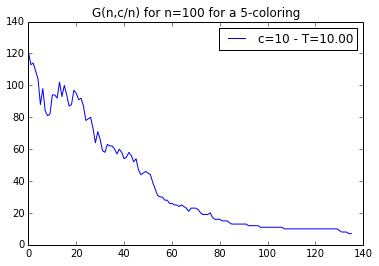

In [29]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import itertools

## Example execution
nb_vertices = 100
mean_degs = [10,] #mean degress for Gnp's
nb_colors = 5
CoolingPeriod = 20 #TODO: optimize, try different parameters.This parameter is really the unit for the x axis in the plot below
T_guess = 10 #This parameter is very sensitive, if increase can augment running time a lot, but also tends to make the initial jump shorter

ct_pairs = zip(mean_degs,itertools.repeat(T_guess,len(mean_degs)))
bsm = BlackSmith(q=nb_colors,n=nb_vertices,T_Period=CoolingPeriod,workline=ct_pairs,desc_thresh=0.5,schedule='Exp')

for c,T,trace in bsm.work():
    plt.plot(trace,label='c=%d - T=%.2f'%(c,T))
plt.legend(loc='best')
plt.title('G(n,c/n) for n=%d for a %d-coloring'%(nb_vertices,nb_colors))

## Interpretation:
- the initial straight line is because our initial gues of T(T_guess) and random point chosen to start  most likely takes us to a region with local minimum only. A high initial T encourages exploration but it also makes overall convergence slower.
- What the algorithm does is go to that local minimum and when it sees that there is a reasonable rate of 'metropolis' steps that we can take opposite to the descent direction then we do it (until it reaches the 'descent regime' again). That is (part of) the spike above.
- 'descent regime' is defined by desc_ratio parameter.
- Once we hit EXACTLY one desc_ratio we just descend until we get 0 stric improvement
- Precision of global optimum depends mostly on CoolingPeriod parameter. This, however, can hurt performance. 
- when L_T and U_T are the same at the end. No strict descent elimination was necessary.(To check)
- Observation: larger mean degree graph requires larger initial temperature.
- colorings close to the mean degree are more interesting and challenging that high nb colorings